In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-03-BIGDATA/master/init.py
import init; init.init(force_download=False); 
from IPython.display import Image

replicating local resources


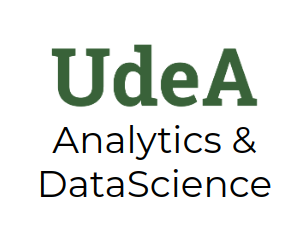

In [ ]:
Image("local/imgs/udea-datascience.png")

In [3]:
#Instalación
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz 
!tar xf spark-3.0.1-bin-hadoop3.2.tgz 
!pip install -q findspark

#Variables de Entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

#SparkContext
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()

In [5]:
#SQL Context
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.types import *
sqlCtx = SQLContext(sc)

#**MACHINE LEARNING**

El Machine Learning o aprendizaje automático es una disciplina orientada a crear sistemas que puedan aprender por sí solos, con el fin de extraer información no trivial de grandes volúmenes de datos por medio de la identificación de patrones complejos.

Spark implementa el aprendizaje automático a través del módulo MLLib que cuenta con un gran número de algoritmos que permiten crear modelos para el aprendizaje automático. Teniendo en cuenta que Spark proporciona sistemas distribuidos para trabajar en paralelo, los algoritmos de Machine Learning implementados en MLLib deben poder ser paralelizables

Pueden identificarse dos grandes ramas en el aprendizaje automático, a saber, el aprendizaje supervisado y el aprendizaje NO supervisado.



##**Preparación de Datos**

Para poder aplicar los métodos del aprendizaje supervisado y no supervisado, es necesario realizar una etapa previa de preparación de datos.

Esta etapa nos permite identificar y corregir posibles anomalías presentes en los datos y contribuir a la etapa de aprendizaje para obtener un buen resultado en la evaluación de los modelos.

###**Pasos**

Para la preparación de datos se recomienda realizar los siguientes pasos

**1. Identificación de variables**

* Propiedades del conjunto de datos
* Tipos de datos (verificar carga correcta de datos)


**2. Tratamiento de duplicados**

* Eliminar variables duplicadas (columnas)
* Eliminar registros duplicados (filas)
* Eliminar variables irrelevantes (ID, cedula, nombre, teléfono)


**3. Análisis univariable**

*  Variables numéricas: estadística descriptiva, histogramas, box plot
*  Variables categóricas: tabla de frecuencias y diagrama de barras


**4. Análisis bivariable**

* Correlaciones entre las variables predictoras deben ser menores a 0.7
* Correlaciones con la variable objetivo debe ser mayor a 0.3


**5. Tratamiento de outliers** (eliminar registros, eliminar variables, imputar, predecir)


**6. Tratamiento de datos nulos** (eliminar registros, eliminar variables, imputar o predecir)


**7. Transformación de variables desde las reglas del negocio**

* Discretización o Binning: convertir de número a categoría
* Crear variables Dummy: convertir de categoría a número


**8. Creación de variables** (fecha y otros)


**9. Reducción de variables** (en caso de ser necesario)


**10. Balanceo de la variable objetivo** (sólo en clasificación)


**11. Transformación datos para el método**

###**Modo Local**

Veamos un ejemplo de cómo realizar estos pasos de la preparación de datos en un ambiente local utilizando pandas (no es un ambiente distribuido)

In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

En el archivo aprobacion_curso.xlsx se encuentran los datos de estudiantes de un curso de universidad, para cada estudiante se tienen los siguientes datos:
* Id: Identificación del estudiante
* Año-Semestre: Momento en el que toma el curso
* Felder: Estilo de aprendizaje del estudiante
* Examen de admisión
* Nota final
* Aprobó: (Si/No)

**1.	Identificación de variables**
* Propiedades del conjunto de datos
* Tipos de datos (verificar carga correcta de datos)

In [7]:
data = pd.read_excel("local/data/aprobacion_curso.xlsx",sheet_name=0) #leer la primera hoja del archivo
type(data)

pandas.core.frame.DataFrame

In [8]:
data.head()

,ID,Año - Semestre,Felder,Examen_admisión,Nota_final,Aprobo
0,1,2016-01,sensorial,4.67,3.1,si
1,2,2016-01,activo,4.17,2.1,no
2,3,2016-01,visual,4.50,3.1,si
3,4,2016-01,visual,3.83,1.6,no
4,5,2016-01,equilibrio,3.00,2.3,no


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               183 non-null    int64  
 1   Año - Semestre   183 non-null    object 
 2   Felder           183 non-null    object 
 3   Examen_admisión  181 non-null    float64
 4   Nota_final       183 non-null    float64
 5   Aprobo           183 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 8.7+ KB


Las variables tipo Object las convertimos a categorías

In [10]:
data['Año - Semestre']=data['Año - Semestre'].astype('category')
data['Felder']=data['Felder'].astype('category')
data['Aprobo']=data['Aprobo'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ID               183 non-null    int64   
 1   Año - Semestre   183 non-null    category
 2   Felder           183 non-null    category
 3   Examen_admisión  181 non-null    float64 
 4   Nota_final       183 non-null    float64 
 5   Aprobo           183 non-null    category
dtypes: category(3), float64(2), int64(1)
memory usage: 5.8 KB


**2.	Tratamiento de duplicados**

* Eliminar variables duplicadas (columnas)
* Eliminar registros duplicados (filas)
* Eliminar variables irrelevantes (ID, cedula, nombre, teléfono)


**Variables Duplicadas:** Las variables Nota Final y Aprobó están duplicadas (representan la misma información), a partir de la nota final podemos saber si un estudiante aprueba o no el curso

In [11]:
data = data.drop('Nota_final',axis=1)

**Registros duplicados:** Dos registros que tengan el mismo Id están duplicados

In [12]:
data=data.drop_duplicates(['ID']) 

**Variables Irrelevantes**: Detectamos dos variables irrelevantes: Id y Año-Semestre

In [13]:
data = data.drop('ID',axis=1)
data = data.drop('Año - Semestre',axis=1)

Así quedan los datos luego de este paso

In [14]:
data.head()

,Felder,Examen_admisión,Aprobo
0,sensorial,4.67,si
1,activo,4.17,no
2,visual,4.50,si
3,visual,3.83,no
4,equilibrio,3.00,no


**3.	Análisis univariable**

* Variables numéricas: estadística descriptiva, histogramas, box plot
* Variables categóricas: tabla de frecuencias y diagrama de barras


Variables numéricas

In [15]:
data.describe() #Solo para datos numéricos

,Examen_admisión
count,181.000000
mean,3.826851
std,0.824674
min,0.000000
25%,3.500000
50%,3.830000
75%,4.330000
max,5.000000


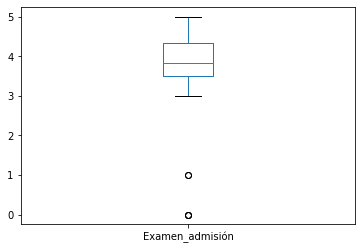

In [16]:
data.plot.box()

Variables categóricas

In [17]:
pd.value_counts(data["Felder"])

visual        63
equilibrio    40
sensorial     28
secuencial    28
activo        15
intuitivo      4
verbal         3
reflexivo      2
Name: Felder, dtype: int64

In [18]:
pd.value_counts(data["Aprobo"])

no    108
si     75
Name: Aprobo, dtype: int64

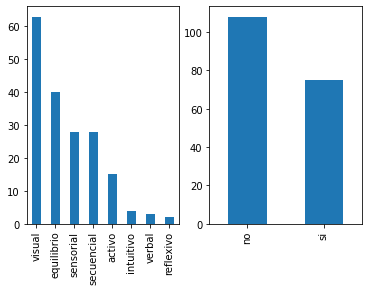

In [19]:
plt.subplot(1,2,1)
pd.value_counts(data["Felder"]).plot(kind="bar")
plt.subplot(1,2,2)
pd.value_counts(data["Aprobo"]).plot(kind="bar")

**4.	Análisis bivariable**

* Correlaciones entre las variables predictoras deben ser menores a 0.7
* Correlaciones con la variable objetivo debe ser mayor a 0.3



In [20]:
data.corr()

,Examen_admisión
Examen_admisión,1.0


La correlación se aplica sobre variables numéricas, debemos convertir las variables categóricas a numéricas

In [21]:
data_num=data #Hacemos una copia de los datos

dummiesFelder = pd.get_dummies(data['Felder'])  #Creamos variables dummy para convertir  las categorías a números
data_num = data_num.drop('Felder', axis=1)      #Elimino la columna original
data_num = data_num.join(dummiesFelder)         #Adiciono las dummies

data_num.head()

,Examen_admisión,Aprobo,activo,equilibrio,intuitivo,reflexivo,secuencial,sensorial,verbal,visual
0,4.67,si,0,0,0,0,0,1,0,0
1,4.17,no,1,0,0,0,0,0,0,0
2,4.50,si,0,0,0,0,0,0,0,1
3,3.83,no,0,0,0,0,0,0,0,1
4,3.00,no,0,1,0,0,0,0,0,0


In [22]:
#Se codifican las categorias de la variable objetivo
data_num["Aprobo"]=data_num["Aprobo"].replace({"si": 1, "no": 0})
data_num.head()

,Examen_admisión,Aprobo,activo,equilibrio,intuitivo,reflexivo,secuencial,sensorial,verbal,visual
0,4.67,1,0,0,0,0,0,1,0,0
1,4.17,0,1,0,0,0,0,0,0,0
2,4.50,1,0,0,0,0,0,0,0,1
3,3.83,0,0,0,0,0,0,0,0,1
4,3.00,0,0,1,0,0,0,0,0,0


Ahora nuestras variables son numéricas, ya podemos aplicar la correlación
* Correlación entre las variables predictoras debe ser menor de 0.7
* Correlación con la variable objetivo debe ser mayor a 0.3

In [23]:
data_num.corr()

,Examen_admisión,Aprobo,activo,equilibrio,intuitivo,reflexivo,secuencial,sensorial,verbal,visual
Examen_admisión,1.000000,0.404302,-0.192819,0.082834,-0.036440,0.033180,0.047427,0.006097,-0.428881,0.118705
Aprobo,0.404302,1.000000,-0.046481,-0.037463,-0.124573,0.019272,0.047056,-0.014673,-0.107583,0.097759
activo,-0.192819,-0.046481,1.000000,-0.158035,-0.044668,-0.031410,-0.127000,-0.127000,-0.038576,-0.216506
equilibrio,0.082834,-0.037463,-0.158035,1.000000,-0.079062,-0.055595,-0.224789,-0.224789,-0.068279,-0.383214
intuitivo,-0.036440,-0.124573,-0.044668,-0.079062,1.000000,-0.015714,-0.063536,-0.063536,-0.019299,-0.108314
reflexivo,0.033180,0.019272,-0.031410,-0.055595,-0.015714,1.000000,-0.044678,-0.044678,-0.013571,-0.076165
secuencial,0.047427,0.047056,-0.127000,-0.224789,-0.063536,-0.044678,1.000000,-0.180645,-0.054870,-0.307959
sensorial,0.006097,-0.014673,-0.127000,-0.224789,-0.063536,-0.044678,-0.180645,1.000000,-0.054870,-0.307959
verbal,-0.428881,-0.107583,-0.038576,-0.068279,-0.019299,-0.013571,-0.054870,-0.054870,1.000000,-0.093541
visual,0.118705,0.097759,-0.216506,-0.383214,-0.108314,-0.076165,-0.307959,-0.307959,-0.093541,1.000000


**5.	Tratamiento de outliers**
(eliminar registros, eliminar variables, imputar, predecir)



In [24]:
data.describe()


,Examen_admisión
count,181.000000
mean,3.826851
std,0.824674
min,0.000000
25%,3.500000
50%,3.830000
75%,4.330000
max,5.000000


Si un estudiante perdió el examen de admisión (nota<3) no debería estar en el curso

In [25]:
data[data["Examen_admisión"]<3] #Consultamos los registros de los outliers
data1=data

In [26]:
#Imputación por la media
media=data["Examen_admisión"].mean()
data.Examen_admisión[data["Examen_admisión"]<3]=media
data.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Examen_admisión
count,181.000000
mean,3.921515
std,0.581555
min,3.000000
25%,3.500000
50%,3.830000
75%,4.330000
max,5.000000


**6.	Tratamiento de datos nulos** 
(eliminar registros, eliminar variables, imputar o predecir)



In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 0 to 182
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Felder           183 non-null    category
 1   Examen_admisión  181 non-null    float64 
 2   Aprobo           183 non-null    category
dtypes: category(2), float64(1)
memory usage: 8.7 KB


Hay dos registros con examen de admisión en null

In [28]:
#Imputación por la media
data['Examen_admisión']=data['Examen_admisión'].fillna(value=data['Examen_admisión'].mean())
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 0 to 182
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Felder           183 non-null    category
 1   Examen_admisión  183 non-null    float64 
 2   Aprobo           183 non-null    category
dtypes: category(2), float64(1)
memory usage: 8.7 KB


**7.	Transformación de variables desde las reglas del negocio** 

* Discretización o Binning: convertir de número a categoría
* Crear variables Dummy: convertir de categoría a número


El examen de admisión que es una variable numérica, podríamos discretizarla para volverla categórica

In [29]:
pd.cut(data["Examen_admisión"],3)

0        (4.333, 5.0]
1      (3.667, 4.333]
2        (4.333, 5.0]
3      (3.667, 4.333]
4      (2.998, 3.667]
            ...      
178    (3.667, 4.333]
179    (2.998, 3.667]
180      (4.333, 5.0]
181    (2.998, 3.667]
182    (2.998, 3.667]
Name: Examen_admisión, Length: 183, dtype: category
Categories (3, interval[float64]): [(2.998, 3.667] < (3.667, 4.333] < (4.333, 5.0]]

El estilo de aprendizaje que es una variable categórica, la podemos volver numérica

In [30]:
pd.get_dummies(data['Felder']).head()

,activo,equilibrio,intuitivo,reflexivo,secuencial,sensorial,verbal,visual
0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0


**8.	Creación de variables** 
(fecha y otros)



Como ejemplo podemos tomar una variable date time y extraer sus componentes

In [31]:
from datetime import datetime

ahora = datetime.now()  # Obtiene fecha y hora actual
print("Fecha y Hora:", ahora)  # Muestra fecha y hora
print("Fecha y Hora UTC:",ahora.utcnow())  # Muestra fecha/hora UTC
print("Día:",ahora.day)  # Muestra día
print("Mes:",ahora.month)  # Muestra mes
print("Año:",ahora.year)  # Muestra año
print("Hora:", ahora.hour)  # Muestra hora
print("Minutos:",ahora.minute)  # Muestra minuto
print("Segundos:", ahora.second)  # Muestra segundo

Fecha y Hora: 2020-10-31 00:17:19.363234
Fecha y Hora UTC: 2020-10-31 00:17:19.363698
Día: 31
Mes: 10
Año: 2020
Hora: 0
Minutos: 17
Segundos: 19


**9.	Reducción de variables** 
(en caso de ser necesario)



Temporalmente eliminamos la variable objetivo para analizar solo las variables predictoras que son en las que debemos aplicar la reducción de variables

In [32]:
X=data_num.drop('Aprobo', axis=1)
#Eliminamos los nulos en la variable Examen admision
X['Examen_admisión']=X['Examen_admisión'].fillna(value=X['Examen_admisión'].mean())
X.head()

,Examen_admisión,activo,equilibrio,intuitivo,reflexivo,secuencial,sensorial,verbal,visual
0,4.67,0,0,0,0,0,1,0,0
1,4.17,1,0,0,0,0,0,0,0
2,4.50,0,0,0,0,0,0,0,1
3,3.83,0,0,0,0,0,0,0,1
4,3.00,0,1,0,0,0,0,0,0


PCA o análisis de componentes principales nos permite convertir nuestras variables originales en un nuevo y reducido grupo de variables que representen a los datos originales con una menor dimensión

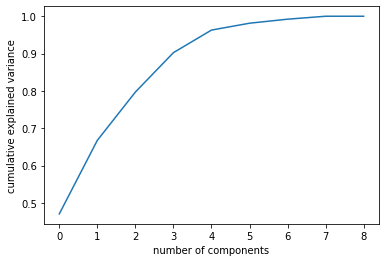

In [33]:
#Seleccionar la cantidad de componentes
from sklearn.decomposition import PCA
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [34]:
#Aplicamos PCA para reducción de variables
pca = PCA(n_components=5)
principalComponents = pca.fit(X)
print("Componentes principales")
print(pca.components_)
print("Varianza acumulada")
varianza = pca.explained_variance_ratio_
var_acum= np.cumsum(varianza)
print(var_acum)


Componentes principales
[[-9.88964926e-01  7.63457244e-02 -4.25204702e-02  7.74470919e-03
  -3.56760538e-03 -1.51622791e-02  7.21028398e-03  6.71502781e-02
  -9.72006411e-02]
 [-6.48123251e-02 -4.10483560e-02 -4.71537643e-01 -1.02139810e-02
  -6.08387597e-03 -1.63895753e-01 -1.58051213e-01  2.43387549e-03
   8.48396947e-01]
 [-5.42967999e-02 -5.38660488e-02  7.33760097e-01 -1.15003501e-02
  -6.93281349e-03 -4.57873193e-01 -4.38980087e-01  4.75830131e-03
   2.30634094e-01]
 [ 1.51581848e-02 -1.01431581e-02 -3.85927579e-03 -6.34031260e-04
   2.41325205e-04 -6.96058168e-01  7.17721848e-01 -5.04007111e-03
  -2.22846898e-03]
 [ 9.31345108e-02  8.82649733e-01 -2.02254422e-01  3.01949713e-02
   1.90212712e-02 -2.75137177e-01 -2.58132027e-01 -3.31048733e-02
  -1.63237476e-01]]
Varianza acumulada
[0.47039739 0.66754967 0.79691266 0.90247351 0.9629312 ]


**10.	Balanceo de la variable objetivo**
(sólo en clasificación) 

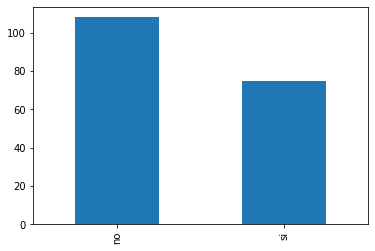

In [35]:
pd.value_counts(data["Aprobo"]).plot(kind="bar")

La variable objetivo (Aprobó) no cuenta con igual número de registros por categoría

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

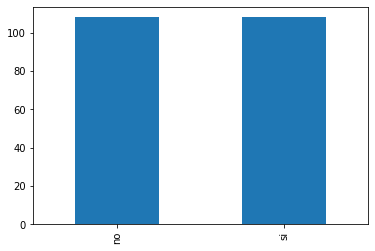

In [36]:
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(random_state=42, categorical_features=[0]) #sm = SMOTE(random_state=42) para datos sólo numéricos
X_bal, Y_bal = sm.fit_resample(data[['Felder', 'Examen_admisión']], data["Aprobo"])
# Creamos un dataframe con los resultados
data_bal = pd.DataFrame({"Felder": X_bal[:,0], "Examen_admisión":X_bal[:,1], "Aprobo": Y_bal})
# Veamos si ahora si está balanceado
pd.value_counts(data_bal["Aprobo"]).plot(kind="bar")

In [37]:
#Guardamos los dataFrame preparados
data.to_excel('local/data/aprobacion_curso_pre.xlsx')
data_bal.to_excel('local/data/aprobacion_curso_bal.xlsx',sheet_name='Data_bal')

###**Modo Distribuido (Spark)**

Ahora veamos que nos ofrece Spark para realizar la preparación de datos en modo distribuido. Nos apoyaremos en los métodos de DataFrame y en la librería de Machine Learning

https://spark.apache.org/docs/latest/api/python/pyspark.ml.html

https://spark.apache.org/docs/latest/ml-guide.html

In [38]:
data = pd.read_excel("local/data/aprobacion_curso.xlsx",sheet_name=0)
estDF=sqlCtx.createDataFrame(data)
type(estDF)

pyspark.sql.dataframe.DataFrame

**Identificación de variables**
* Propiedades del conjunto de datos
* Tipos de datos (verificar carga correcta de datos)

In [39]:
estDF.printSchema()
estDF.show(5)

root
 |-- ID: long (nullable = true)
 |-- Año - Semestre: string (nullable = true)
 |-- Felder: string (nullable = true)
 |-- Examen_admisión: double (nullable = true)
 |-- Nota_final: double (nullable = true)
 |-- Aprobo: string (nullable = true)

+---+--------------+----------+---------------+----------+------+
| ID|Año - Semestre|    Felder|Examen_admisión|Nota_final|Aprobo|
+---+--------------+----------+---------------+----------+------+
|  1|       2016-01| sensorial|           4.67|       3.1|    si|
|  2|       2016-01|    activo|           4.17|       2.1|    no|
|  3|       2016-01|    visual|            4.5|       3.1|    si|
|  4|       2016-01|    visual|           3.83|       1.6|    no|
|  5|       2016-01|equilibrio|            3.0|       2.3|    no|
+---+--------------+----------+---------------+----------+------+
only showing top 5 rows



En pandas nos muestra información sobre los registros que tienen valores null, DataFrames no nos muestra esa información y a demás las variables categóricas las trabajamos como String

**Tratamiento de duplicados**

* Eliminar variables duplicadas (columnas)
* Eliminar registros duplicados (filas)
* Eliminar variables irrelevantes (ID, cedula, nombre, teléfono)


In [40]:
estDF=estDF.dropDuplicates(['ID'])
estDF=estDF.drop('ID','Año - Semestre','Nota_final')
estDF.printSchema()

root
 |-- Felder: string (nullable = true)
 |-- Examen_admisión: double (nullable = true)
 |-- Aprobo: string (nullable = true)



**Análisis univariable**

* Variables numéricas: estadística descriptiva, histogramas, box plot
* Variables categóricas: tabla de frecuencias y diagrama de barras


Variables numéricas

In [41]:
estDF.select('Examen_admisión').describe().show()
estDF.select('Examen_admisión').distinct().show()

+-------+---------------+
|summary|Examen_admisión|
+-------+---------------+
|  count|            183|
|   mean|            NaN|
| stddev|            NaN|
|    min|            0.0|
|    max|            NaN|
+-------+---------------+

+---------------+
|Examen_admisión|
+---------------+
|            0.0|
|            3.5|
|           3.33|
|            NaN|
|            4.5|
|           4.33|
|           3.83|
|            1.0|
|           3.67|
|            4.0|
|           4.83|
|           4.67|
|            3.0|
|           4.17|
|           3.17|
|            5.0|
+---------------+



Encontró problemas con la variable examen de admisión, no puede calcular la estadística descriptiva de la variable hasta no resolver esos problemas

In [42]:
estDF=estDF.fillna(3.0,'Examen_admisión')
estDF.select('Examen_admisión').describe().show()

+-------+------------------+
|summary|   Examen_admisión|
+-------+------------------+
|  count|               183|
|   mean|3.8178142076502732|
| stddev|0.8246481956629872|
|    min|               0.0|
|    max|               5.0|
+-------+------------------+



Variables categóricas

In [43]:
estDF.groupBy('Felder').count().show()
estDF.groupBy('Aprobo').count().show()


+----------+-----+
|    Felder|count|
+----------+-----+
|equilibrio|   40|
|    activo|   15|
|    visual|   63|
| reflexivo|    2|
| sensorial|   28|
| intuitivo|    4|
|secuencial|   28|
|    verbal|    3|
+----------+-----+

+------+-----+
|Aprobo|count|
+------+-----+
|    si|   75|
|    no|  108|
+------+-----+



**Análisis bivariable**

* Correlaciones entre las variables predictoras deben ser menores a 0.7
* Correlaciones con la variable objetivo debe ser mayor a 0.3



La correlación se aplica sobre variables numéricas, debemos convertir las variables categóricas a numéricas

In [44]:
estNum=estDF
estNum.select('Felder').distinct().show()

+----------+
|    Felder|
+----------+
|equilibrio|
|    activo|
|    visual|
| reflexivo|
| sensorial|
| intuitivo|
|secuencial|
|    verbal|
+----------+



In [45]:
from pyspark.sql.types import *
estNum=estNum.\
  withColumn('equilibrio',(estNum.Felder=='equilibrio').cast(IntegerType())).\
  withColumn('activo',(estNum.Felder=='activo').cast(IntegerType())).\
  withColumn('visual',(estNum.Felder=='visual').cast(IntegerType())).\
  withColumn('reflexivo',(estNum.Felder=='reflexivo').cast(IntegerType())).\
  withColumn('sensorial',(estNum.Felder=='sensorial').cast(IntegerType())).\
  withColumn('intuitivo',(estNum.Felder=='intuitivo').cast(IntegerType())).\
  withColumn('secuencial',(estNum.Felder=='secuencial').cast(IntegerType())).\
  withColumn('verbal',(estNum.Felder=='verbal').cast(IntegerType())).\
  withColumn('AproboInt',(estNum.Aprobo=='si').cast(IntegerType()))
estNum=estNum.drop('Felder','Aprobo')

estNum.printSchema()
estNum.show(5)

root
 |-- Examen_admisión: double (nullable = false)
 |-- equilibrio: integer (nullable = true)
 |-- activo: integer (nullable = true)
 |-- visual: integer (nullable = true)
 |-- reflexivo: integer (nullable = true)
 |-- sensorial: integer (nullable = true)
 |-- intuitivo: integer (nullable = true)
 |-- secuencial: integer (nullable = true)
 |-- verbal: integer (nullable = true)
 |-- AproboInt: integer (nullable = true)

+---------------+----------+------+------+---------+---------+---------+----------+------+---------+
|Examen_admisión|equilibrio|activo|visual|reflexivo|sensorial|intuitivo|secuencial|verbal|AproboInt|
+---------------+----------+------+------+---------+---------+---------+----------+------+---------+
|           3.33|         1|     0|     0|        0|        0|        0|         0|     0|        0|
|           4.33|         0|     0|     1|        0|        0|        0|         0|     0|        0|
|           4.83|         0|     0|     0|        0|        0|        

Ahora nuestras variables son numéricas, ya podemos aplicar la correlación
* Correlación entre las variables predictoras debe ser menor de 0.7
* Correlación con la variable objetivo debe ser mayor a 0.3

Tenemos el método corr que calcula la correlación entre dos variables

In [46]:
estNum.corr('equilibrio','activo')

-0.1580348853102535

La librería ml.stat cuenta con un método para calcular la correlación pero requiere definir los datos dentro de un vector

In [47]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler


vector_col = "corr_features"
assembler = VectorAssembler(inputCols=estNum.columns, outputCol=vector_col)
df_vector = assembler.transform(estNum).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col)

matrix.collect()[0]["pearson({})".format(vector_col)].values

array([ 1.        ,  0.08806434, -0.18838437,  0.11366537,  0.03415153,
        0.01072762, -0.03459361,  0.03583002, -0.42507384,  0.40969831,
        0.08806434,  1.        , -0.15803489, -0.38321423, -0.05559525,
       -0.22478905, -0.07906157, -0.22478905, -0.06827887, -0.03746275,
       -0.18838437, -0.15803489,  1.        , -0.21650635, -0.03140991,
       -0.12700013, -0.04466779, -0.12700013, -0.03857584, -0.04648111,
        0.11366537, -0.38321423, -0.21650635,  1.        , -0.07616499,
       -0.30795894, -0.10831364, -0.30795894, -0.09354143,  0.09775929,
        0.03415153, -0.05559525, -0.03140991, -0.07616499,  1.        ,
       -0.0446775 , -0.01571373, -0.0446775 , -0.01357063,  0.01927157,
        0.01072762, -0.22478905, -0.12700013, -0.30795894, -0.0446775 ,
        1.        , -0.06353553, -0.18064516, -0.05487033, -0.01467344,
       -0.03459361, -0.07906157, -0.04466779, -0.10831364, -0.01571373,
       -0.06353553,  1.        , -0.06353553, -0.01929869, -0.12

**Tratamiento de outliers y de nulos**
(eliminar registros, eliminar variables, imputar, predecir)



Si un estudiante perdió el examen de admisión (nota<3) no debería estar en el curso

In [48]:
prom=estNum.agg(functions.avg(estNum.Examen_admisión)).take(1)[0][0]
prom


3.8178142076502732

In [49]:
estNum = estNum.withColumn('Examen_admisión', functions.when(estNum.Examen_admisión<3,prom)\
                                                 .when(estNum.Examen_admisión>=3, estNum.Examen_admisión))
estNum.describe().show()

+-------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|summary|   Examen_admisión|        equilibrio|             activo|            visual|          reflexivo|          sensorial|          intuitivo|         secuencial|             verbal|          AproboInt|
+-------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|  count|               183|               183|                183|               183|                183|                183|                183|                183|                183|                183|
|   mean|3.9111971094986413|0.2185792349726776|0.08196721311475409|0.3442622950819672|0.01092896174863388|0.15300546448087432|0.02185792349726776|0.15300546448087432|0.0163

**Transformación de variables desde las reglas del negocio** 

* Discretización o Binning: convertir de número a categoría
* Crear variables Dummy: convertir de categoría a número


El examen de admisión que es una variable numérica, podríamos discretizarla para volverla categórica

In [50]:
from pyspark.ml.feature import QuantileDiscretizer

discretizer = QuantileDiscretizer(numBuckets=3, inputCol="Examen_admisión", outputCol="ExamenCat")

result = discretizer.fit(estNum).transform(estNum)
result.show()

+------------------+----------+------+------+---------+---------+---------+----------+------+---------+---------+
|   Examen_admisión|equilibrio|activo|visual|reflexivo|sensorial|intuitivo|secuencial|verbal|AproboInt|ExamenCat|
+------------------+----------+------+------+---------+---------+---------+----------+------+---------+---------+
|              3.33|         1|     0|     0|        0|        0|        0|         0|     0|        0|      0.0|
|              4.33|         0|     0|     1|        0|        0|        0|         0|     0|        0|      2.0|
|              4.83|         0|     0|     0|        0|        0|        0|         1|     0|        1|      2.0|
|               5.0|         0|     0|     1|        0|        0|        0|         0|     0|        1|      2.0|
|               5.0|         0|     0|     0|        0|        0|        0|         1|     0|        1|      2.0|
|              3.83|         1|     0|     0|        0|        0|        0|         0|  

La variable Aprobó es categórica, podemos convertirla a númerica

In [51]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="Aprobo", outputCol="AproboNum")
indexer.fit(estDF).transform(estDF).show()

+----------+---------------+------+---------+
|    Felder|Examen_admisión|Aprobo|AproboNum|
+----------+---------------+------+---------+
|equilibrio|           3.33|    no|      0.0|
|    visual|           4.33|    no|      0.0|
|secuencial|           4.83|    si|      1.0|
|    visual|            5.0|    si|      1.0|
|secuencial|            5.0|    si|      1.0|
|equilibrio|           3.83|    no|      0.0|
|    visual|            3.5|    no|      0.0|
|equilibrio|           4.17|    no|      0.0|
|    activo|            1.0|    no|      0.0|
|equilibrio|            5.0|    si|      1.0|
|    activo|            4.0|    si|      1.0|
| sensorial|           3.83|    no|      0.0|
|equilibrio|            4.0|    no|      0.0|
|secuencial|            3.5|    no|      0.0|
|    visual|            5.0|    si|      1.0|
|equilibrio|           4.67|    si|      1.0|
|secuencial|           4.83|    no|      0.0|
|    visual|            3.5|    no|      0.0|
|    visual|           4.83|    si

**Reducción de variables** 
(en caso de ser necesario)



In [ ]:
estNum.columns

Creamos un vector que contiene las variables predictoras (eliminamos la variable objetivo)

In [53]:
# convert to vector column first
vector_col = "features"
assembler = VectorAssembler(inputCols=estNum.drop('AproboInt').columns, outputCol=vector_col)
vest = assembler.transform(estNum)
df_vector = vest.select(vector_col)

In [54]:
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors

pca = PCA(k=3, inputCol=vector_col, outputCol="pcaFeatures")
model = pca.fit(df_vector)
result = model.transform(df_vector).select("pcaFeatures")
result.show(truncate=False)

+---------------------------------------------------------------+
|pcaFeatures                                                    |
+---------------------------------------------------------------+
|[-3.0783914139835393,-1.535227896008717,0.2747570301727362]    |
|[-4.373018774196732,-0.5683493781311031,-0.3394078068433431]   |
|[-4.458030098647962,-1.6567928374310277,-1.1103595677202502]   |
|[-5.000885150943487,-0.7788078850200455,-0.42993280139317386]  |
|[-4.617339477822512,-1.710192757089416,-1.1333285961881177]    |
|[-3.546948411555745,-1.6922864832392708,0.207201064090773]     |
|[-3.5952141582268693,-0.30763212332838363,-0.22726490314728415]|
|[-3.865567169904845,-1.7990863225560474,0.16126300715503794]   |
|[-3.5095944750031176,-1.228230506164229,-0.578172977919183]    |
|[-4.643371785874707,-2.059803577358767,0.04912010345897899]    |
|[-3.6803233307305203,-1.285458192484083,-0.6027884523363705]   |
|[-3.486177134516737,-1.3242542124561072,-0.9448390245932783]   |
|[-3.70625

##**Aprendizaje Supervisado**

El aprendizaje supervisado utiliza un conjunto histórico de datos donde se tienen los registros previamente catalogados, para crear un modelo de predicción. Este modelo de predicción aprende de los datos históricos hasta obtener la capacidad de predecir lo que pasará con nuevos conjuntos de datos.

Se caracterizan por disponer de una variable objetivo o variable de clase, que es justamente lo que se quiere predecir. Esta variable objetivo puede ser numérica (regresión) o categórica (clasificación)

El **ciclo de vida** del aprendizaje supervisado consta de tres fases

* **Modelamiento:** Consiste en construir el modelo que permita predecir la variable objetivo
* **Evaluación:** Se evalúa el modelo predictivo construido para ver que tanto podemos confiar en el
* **Validación:** Una vez el modelo ha sido evaluado y el resultado es el esperado, se someten datos nuevos al modelo para realizar la predicción

La etapa de modelamiento y evaluación requieren del conjunto histórico de datos. Esto significa que debemos decidir la forma como se utilizarán los datos históricos en estas dos etapas. Para esto disponemos de tres opciones:

* **Evaluar el mismo conjunto de entrenamiento**
* **División de datos (Split / 70-30)**
* **Validación cruzada**

###**Predicción continua o Regresión**

Es el estudio de un conjunto de datos históricos con el fin de predecir un evento numérico futuro.

Es decir que la variable objetivo a predecir es de tipo numérica.

**Evaluación**

Como la variable a predecir es numérica el error de predicción se calcula al comparar el valor real contra el valor de la predicción y esto se hace con una fórmula matemática de cálculo de error. Existen varias formas de calcular ese error:

* Error medio absoluto:

$$error = \frac{\sum_ {i=1}^n  |f(x)-p(x)|}{n}$$

* Error cuadrático medio:
$$error = \frac{1}{n}\sum(f(x)-p(x))^2$$


Donde, 
* $f(x)$: Valor real
* $p(x)$: predicción

####**Regresión lineal**

Permite evaluar la relación entre una variable dependiente (variable a predecir) y un conjunto de variables independientes (variables predictoras)


$$Y = \alpha + \beta_1 X_1  +  \beta_2 X_2 + ... + \beta_n X_n + \epsilon$$

Donde,
* $Y$: Variable a predecir
* $X$: Variables predictoras (atributos)
* $\alpha$: Intercepto
* $\beta$: Pendiente
* $\epsilon$: Error

Básicamente lo que se hace es encontrar la ecuación de la recta que mejor represente al conjunto de datos, de modo que se pueda utilizar dicha ecuación para la predicción de nuevos registros




**Ejemplo: Predicción del precio de venta de una propiedad en Boston**


Tomado de: https://www.kaggle.com/kyasar/boston-housing

**1. Preparar**

Carga de datos

In [55]:
boston = sqlCtx.read.format("csv") \
      .option("header", True) \
      .option("delimiter", ",") \
      .option("inferschema",True) \
      .load("local/data/boston_housing.csv")
boston.cache()
boston.printSchema()

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: double (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



Esta es la descripción de las variables disponibles:

* crim : Tasa de delincuencia per cápita por población
* zn:  Proporción de terreno residencial dividido en zonas para lotes de más de 25,000 pies cuadrados.
* indus : Proporción de terrenos comerciales no minoristas por población.
* chas: Indica si la propiedad limita o no con el río (1 si limita con el río. 0 en caso contrario).
* nox: Concentración de óxidos nítricos (partes por 10 millones).
* rm : Promedio de habitaciones por vivienda.
* age : Proporción de unidades ocupadas por sus propietarios construidas antes de 1940
* dis : Distancias ponderadas a cinco centros de empleo de Boston
* rad: índice de accesibilidad a carreteras principales.
* tax : tasa de impuesto a la propiedad.
* ptratio: Proporción alumno-profesor.
* black: Proporción de negros por ciudad.
* lstat: Estatus más bajo de la población (porcentaje).
* **mv : valor medio de las viviendas en $ 1000. Esta es la variable objetivo.**

Descripción estadística de los datos

In [56]:
boston.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              crim|                zn|             indus|              chas|                nox|                rm|               age|              dis|              rad|               tax|           ptratio|             black|             lstat|              medv|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|               506|               506|               506|               506|                506|               506|               506|              506|              

In [57]:
boston.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
crim,506,3.6135235573122535,8.601545105332491,0.00632,88.9762
zn,506,11.363636363636363,23.32245299451514,0.0,100.0
indus,506,11.136778656126504,6.860352940897589,0.46,27.74
chas,506,0.0691699604743083,0.2539940413404101,0,1
nox,506,0.5546950592885372,0.11587767566755584,0.385,0.871
rm,506,6.284634387351787,0.7026171434153232,3.561,8.78
age,506,68.57490118577078,28.148861406903595,2.9,100.0
dis,506,3.795042687747034,2.10571012662761,1.1296,12.1265
rad,506,9.549407114624506,8.707259384239366,1,24


Análisis de correlación

In [58]:
import six
print("Correlación con la variable objetivo")
for i in boston.columns:
    if not( isinstance(boston.select(i).take(1)[0][0], six.string_types)):
        print( "", i, boston.stat.corr('medv',i))

Correlación con la variable objetivo
 crim -0.38830460858681154
 zn 0.3604453424505433
 indus -0.4837251600283728
 chas 0.1752601771902987
 nox -0.4273207723732821
 rm 0.6953599470715401
 age -0.3769545650045961
 dis 0.249928734085904
 rad -0.38162623063977735
 tax -0.46853593356776674
 ptratio -0.5077866855375622
 black 0.3334608196570661
 lstat -0.7376627261740145
 medv 1.0


Si dispone de muchas variables, se recomienda eliminar aquellas que presentan una correlación baja con la variable objetivo (<0.3)

In [59]:
boston=boston.drop("chas","dis")
boston.columns

['crim',
 'zn',
 'indus',
 'nox',
 'rm',
 'age',
 'rad',
 'tax',
 'ptratio',
 'black',
 'lstat',
 'medv']

Para aplicar la técnica de Machine Learning se requiere representar los datos mediante dos columnas, una con las variables predictoras (features) y la otra es la variable objetivo

In [60]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = \
    ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'rad', 'tax', 'ptratio', 'black', 'lstat'], outputCol = 'features')
vboston = vectorAssembler.transform(boston)
vboston.show(1)

+-------+----+-----+-----+-----+----+---+-----+-------+-----+-----+----+--------------------+
|   crim|  zn|indus|  nox|   rm| age|rad|  tax|ptratio|black|lstat|medv|            features|
+-------+----+-----+-----+-----+----+---+-----+-------+-----+-----+----+--------------------+
|0.00632|18.0| 2.31|0.538|6.575|65.2|  1|296.0|   15.3|396.9| 4.98|24.0|[0.00632,18.0,2.3...|
+-------+----+-----+-----+-----+----+---+-----+-------+-----+-----+----+--------------------+
only showing top 1 row



Nos quedamos solo con las variables features y medv

In [61]:
vboston = vboston.select(['features', 'medv'])
vboston.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
+--------------------+----+
only showing top 3 rows



Ahora veamos la correlación entre las variables predictoras

In [62]:
matrix = Correlation.corr(vboston,"features")
matrix.collect()[0]["pearson({})".format("features")].values

array([ 1.        , -0.20046922,  0.40658341,  0.42097171, -0.2192467 ,
        0.35273425,  0.62550515,  0.58276431,  0.28994558, -0.38506394,
        0.45562148, -0.20046922,  1.        , -0.53382819, -0.51660371,
        0.31199059, -0.56953734, -0.31194783, -0.31456332, -0.39167855,
        0.17552032, -0.41299457,  0.40658341, -0.53382819,  1.        ,
        0.76365145, -0.39167585,  0.64477851,  0.59512927,  0.72076018,
        0.38324756, -0.35697654,  0.60379972,  0.42097171, -0.51660371,
        0.76365145,  1.        , -0.30218819,  0.7314701 ,  0.61144056,
        0.6680232 ,  0.18893268, -0.38005064,  0.59087892, -0.2192467 ,
        0.31199059, -0.39167585, -0.30218819,  1.        , -0.24026493,
       -0.20984667, -0.29204783, -0.35550149,  0.12806864, -0.61380827,
        0.35273425, -0.56953734,  0.64477851,  0.7314701 , -0.24026493,
        1.        ,  0.45602245,  0.50645559,  0.26151501, -0.27353398,
        0.60233853,  0.62550515, -0.31194783,  0.59512927,  0.61

In [63]:
print("Correlación entre tax y indus: ",boston.corr("tax","indus"))
print("Correlación entre nox y indus: ",boston.corr("nox","indus"))
print("Correlación entre nox y age: ",  boston.corr("nox","age"))
print("Correlación entre tax y rad: ",  boston.corr("tax","rad"))


Correlación entre tax y indus:  0.7207601799515422
Correlación entre nox y indus:  0.7636514469209139
Correlación entre nox y age:  0.7314701037859592
Correlación entre tax y rad:  0.9102281885331867


Eliminemos las variables correlacionadas y creemos nuevamente el vector de características

In [64]:
boston=boston.drop("tax","nox")
vectorAssembler = VectorAssembler(inputCols = \
    ['crim', 'zn', 'indus', 'rm', 'age', 'rad', 'ptratio', 'black', 'lstat'], outputCol = 'features')
vboston = vectorAssembler.transform(boston)
vboston = vboston.select(['features', 'medv'])
vboston.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
+--------------------+----+
only showing top 3 rows



Creamos los conjuntos de datos de entrenamiento y evaluación (Split)

In [65]:
(trainingData, testData) = vboston.randomSplit([0.7, 0.3])
print(trainingData.count())
print(testData.count())

342
164


**2. Modelar**

In [66]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(trainingData)
trainingSummary = lr_model.summary

Veamos la predicción con los datos de entrenamiento

In [67]:
trainingSummary.predictions.select("prediction","medv").show(5)

+------------------+----+
|        prediction|medv|
+------------------+----+
| 30.49880674360513|24.0|
|28.320857571004712|22.0|
| 33.08567588427545|32.7|
| 31.58707747621996|35.4|
|17.981130323782487|18.9|
+------------------+----+
only showing top 5 rows



El método de regresión lineal construye la ecuación de la recta que mas se ajuste a los datos.

In [68]:
print("Coeficientes: " + str(lr_model.coefficients))
print("Intercepto: " + str(lr_model.intercept))
print("Variables:")
boston.columns

Coeficientes: [-0.0366239682292049,0.0,0.0,4.522111486667675,0.0,0.0,-0.7833959799337836,0.007020799526100686,-0.4956234747838383]
Intercepto: 12.433763247745416
Variables:


['crim',
 'zn',
 'indus',
 'rm',
 'age',
 'rad',
 'ptratio',
 'black',
 'lstat',
 'medv']

Veamos las medidas de error

In [69]:
print("Error cuadrático medio (MSE): %f" % trainingSummary.meanSquaredError)
print("Error medio absoluto (MAE): %f" % trainingSummary.meanAbsoluteError)
print("Raíz del Error cuadrático medio (RMSE): %f" % trainingSummary.rootMeanSquaredError)
print("Coeficiente de determinación (r2): %f" % trainingSummary.r2)
print("Coeficiente de determinación ajustado (r2Adj): %f" % trainingSummary.r2adj)

Error cuadrático medio (MSE): 28.511695
Error medio absoluto (MAE): 3.691872
Raíz del Error cuadrático medio (RMSE): 5.339634
Coeficiente de determinación (r2): 0.664617
Coeficiente de determinación ajustado (r2Adj): 0.655525



**3. Evaluar**

In [70]:
from pyspark.ml.evaluation import RegressionEvaluator

lr_predictions = lr_model.transform(testData)
lr_predictions.select("prediction","medv").show(5)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="medv",metricName="r2")
print("Coeficiente de determinación con los datos de evaluación = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+
|        prediction|medv|
+------------------+----+
| 31.38080487099618|32.2|
|30.550187561757816|29.1|
| 34.85604959412374|44.0|
|31.873214667182246|32.9|
|27.479375844253852|23.1|
+------------------+----+
only showing top 5 rows

Coeficiente de determinación con los datos de evaluación = 0.73275


In [71]:
test_result = lr_model.evaluate(testData)
print("Error cuadrático medio con los datos de evaluación = %g" % test_result.meanSquaredError)
print("Raiz del Error cuadrático medio con los datos de evaluación = %g" % test_result.rootMeanSquaredError)
print("Error medio absoluto con los datos de evaluación = %g" % test_result.meanAbsoluteError)
print("Coeficiente de determinación con los datos de evaluación = %g" % test_result.r2)
print("Coeficiente de determinación ajustado con los datos de evaluación = %g" % test_result.r2adj)

Error cuadrático medio con los datos de evaluación = 22.2226
Raiz del Error cuadrático medio con los datos de evaluación = 4.71409
Error medio absoluto con los datos de evaluación = 3.19432
Coeficiente de determinación con los datos de evaluación = 0.73275
Coeficiente de determinación ajustado con los datos de evaluación = 0.717131


####**Árboles de decisión para regresión**

El método de árboles de decisión está disponible tanto para predecir números (árboles de regresión) como para predecir categorías (árboles de clasificación).

Su funcionamiento se basa en representar el conjunto histórico de datos a través de un árbol en el que tendremos dos componentes:
* Nodos: presentan una pregunta sobre algunos de los atributos y se genera una bifurcación a partir de la respuesta
* Hojas: Están al final de cada rama y son los valores de la predicción


Cuando se somete un registro al árbol de decisión, este recorre el árbol a través de las respuestas generadas en cada nodo, y al final llegará a una hoja que indica la predicción.

En el caso de los árboles de regresión, la variable a predecir es numérica, es decir que el resultado final de la predicción será un número 

**Ejemplo: Predicción del precio de venta de una propiedad en Boston**

**Modelar**

In [72]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'medv')
dt_model = dt.fit(trainingData)

Veamos la predicción con los datos de entrenamiento

In [73]:
dt_model.transform(trainingData).select("prediction","medv").show(5)

+------------------+----+
|        prediction|medv|
+------------------+----+
|            26.325|24.0|
|22.099999999999984|22.0|
| 32.45357142857143|32.7|
| 32.45357142857143|35.4|
| 19.91538461538461|18.9|
+------------------+----+
only showing top 5 rows



**Evaluar**

In [74]:
dt_predictions = dt_model.transform(testData)
dt_predictions.select("prediction","medv").show(5)

dt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="r2")
print("Coeficiente de determinación con los datos de evaluación = %g" % dt_evaluator.evaluate(dt_predictions))

+-----------------+----+
|       prediction|medv|
+-----------------+----+
|             34.5|32.2|
|           26.325|29.1|
|40.44999999999999|44.0|
|32.45357142857143|32.9|
|             28.7|23.1|
+-----------------+----+
only showing top 5 rows

Coeficiente de determinación con los datos de evaluación = 0.784996


Veamos la importancia de las vaiables predictoras

In [75]:
dt_model.featureImportances

SparseVector(9, {0: 0.099, 1: 0.0002, 2: 0.0121, 3: 0.2189, 4: 0.0252, 6: 0.0212, 7: 0.0061, 8: 0.6173})

In [76]:
boston.columns

['crim',
 'zn',
 'indus',
 'rm',
 'age',
 'rad',
 'ptratio',
 'black',
 'lstat',
 'medv']

###**Predicción discreta o Clasificación**

La clasificación permite predecir un evento numérico discreto, es decir que lo que pedimos ya no es un número sino una categoría, una cualidad.

Se utiliza el conjunto histórico de datos donde se cuenta con una variable objetivo que es de tipo categórica. Con ese histórico de datos, se crea un modelo que aprenderá de los datos y permitirá predecir datos futuros

**Evaluación**

Teniendo en cuenta que la variable objetivo es categórica, contamos con la clase real a la que pertenece cada uno de los registros que hacen parte del histórico de datos.

Por otro lado, el modelo arrojará como resultado una predicción sobre la clase a la que debe pertenecer cada registro. Usando la clase real y la predicción se construyen unas medidas de error que permiten evaluar la calidad del modelo. 

Estas medidas se construyen al identificar la cantidad de registros que quedaron clasificados correctamente es decir que la clase de la predicción y la clase real coinciden

Con esta información se construye lo que se conoce como matriz de confusión


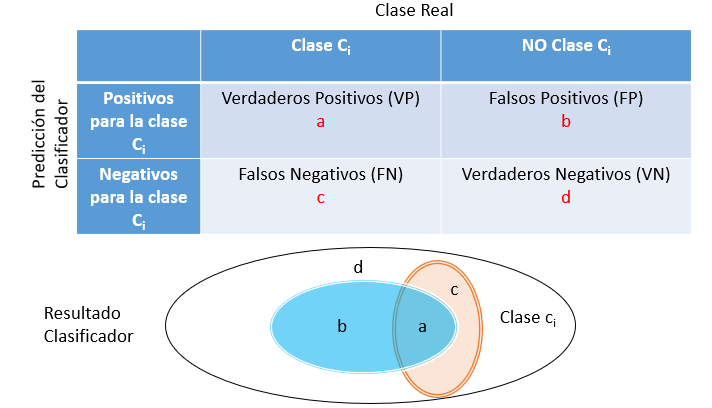

In [77]:
Image("local/imgs/matriz_confusion.png")

las cantidades relacionadas en la matriz de confusión nos permiten calcular esas medidas de error entre las cuales se destacan:

* Precisión: $$p=\frac{a}{a+b}$$
* Cobertura: $$r=\frac{a}{a+c}$$
* Exactitud: $$e=\frac{a+d}{a+b+c+d}$$
* Media armónica: $$f=\frac{2pr}{p+r}$$
* Razón de verdaderos positivos: $$VPR=\frac{a}{a+c}$$
* Razón de falsos positivos: $$FPR=\frac{b}{b+d}$$

Donde,

* $a$: Verdaderos positivos
* $b$: Falsos positivos
* $c$: Falsos negativos
* $d$: Verdaderos negativos

Con la razón de verdaderos positivos y la razón de falsos positivos se calcula el área ROC, medida utilizada ampliamente para evaluar modelos predictivos de clasificación.


####**Regresión Logística**

El funcionamiento es similar a la regresión lineal, donde se calculaba la ecuación de la recta que mejor represente al conjunto de datos con el fin de predecir una variable numérica.

La regresión logística aplica ese principio, pero teniendo en cuenta que la variable a predecir es categórica y puede tener n categorías,
lo que propone es calcular las ecuaciones de n rectas, una para cada categoría 

**Ejemplo: Aprobación curso**

**1. Preparar**

In [78]:
data = pd.read_excel("local/data/aprobacion_curso_bal.xlsx",sheet_name=0)
estDF=sqlCtx.createDataFrame(data).drop('Unnamed: 0')
estDF.show(5)

+----------+---------------+------+
|    Felder|Examen_admisión|Aprobo|
+----------+---------------+------+
| sensorial|           4.67|    si|
|    activo|           4.17|    no|
|    visual|            4.5|    si|
|    visual|           3.83|    no|
|equilibrio|            3.0|    no|
+----------+---------------+------+
only showing top 5 rows



In [79]:
estDF=sqlCtx.createDataFrame(data)
estDF=estDF.\
  withColumn('equilibrio',(estDF.Felder=='equilibrio').cast(IntegerType())).\
  withColumn('activo',(estDF.Felder=='activo').cast(IntegerType())).\
  withColumn('visual',(estDF.Felder=='visual').cast(IntegerType())).\
  withColumn('reflexivo',(estDF.Felder=='reflexivo').cast(IntegerType())).\
  withColumn('sensorial',(estDF.Felder=='sensorial').cast(IntegerType())).\
  withColumn('intuitivo',(estDF.Felder=='intuitivo').cast(IntegerType())).\
  withColumn('secuencial',(estDF.Felder=='secuencial').cast(IntegerType())).\
  withColumn('verbal',(estDF.Felder=='verbal').cast(IntegerType())).\
  withColumn('AproboInt',(estDF.Aprobo=='si').cast(IntegerType()))
estDF=estDF.drop('Felder','Aprobo','Unnamed: 0')
estDF.printSchema()
estDF.show(5)

root
 |-- Examen_admisión: double (nullable = true)
 |-- equilibrio: integer (nullable = true)
 |-- activo: integer (nullable = true)
 |-- visual: integer (nullable = true)
 |-- reflexivo: integer (nullable = true)
 |-- sensorial: integer (nullable = true)
 |-- intuitivo: integer (nullable = true)
 |-- secuencial: integer (nullable = true)
 |-- verbal: integer (nullable = true)
 |-- AproboInt: integer (nullable = true)

+---------------+----------+------+------+---------+---------+---------+----------+------+---------+
|Examen_admisión|equilibrio|activo|visual|reflexivo|sensorial|intuitivo|secuencial|verbal|AproboInt|
+---------------+----------+------+------+---------+---------+---------+----------+------+---------+
|           4.67|         0|     0|     0|        0|        1|        0|         0|     0|        1|
|           4.17|         0|     1|     0|        0|        0|        0|         0|     0|        0|
|            4.5|         0|     0|     1|        0|        0|        0

In [80]:
vectorAssembler = VectorAssembler(inputCols = \
    ['Examen_admisión', 'equilibrio', 'activo', 'visual', 'reflexivo', 'sensorial', 'intuitivo', \
     'secuencial', 'verbal'], outputCol = 'features')
vest = vectorAssembler.transform(estDF)
vest = vest.select(['features', 'AproboInt'])
vest.show(5)

+--------------------+---------+
|            features|AproboInt|
+--------------------+---------+
|(9,[0,5],[4.67,1.0])|        1|
|(9,[0,2],[4.17,1.0])|        0|
| (9,[0,3],[4.5,1.0])|        1|
|(9,[0,3],[3.83,1.0])|        0|
| (9,[0,1],[3.0,1.0])|        0|
+--------------------+---------+
only showing top 5 rows



Creamos los conjuntos de datos de entrenamiento y evaluación (Split)

In [81]:
(trainingData, testData) = vest.randomSplit([0.7, 0.3])
print(trainingData.count())
print(testData.count())

142
74


**2. Modelar**

In [82]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="AproboInt", featuresCol="features",maxIter=10)
lr_model=lr.fit(trainingData)

In [83]:
trainingSummary = lr_model.summary
trainingSummary.predictions.select('AproboInt','prediction','probability').show(5)

+---------+----------+--------------------+
|AproboInt|prediction|         probability|
+---------+----------+--------------------+
|      0.0|       0.0|[0.90810574583581...|
|      0.0|       0.0|[0.90810574583581...|
|      0.0|       0.0|[0.87980748617864...|
|      0.0|       0.0|[0.84180731202122...|
|      0.0|       0.0|[0.84180731202122...|
+---------+----------+--------------------+
only showing top 5 rows



In [84]:
print("Coeficientes: " + str(lr_model.coefficients))
print("Intercepto: " + str(lr_model.intercept))
estDF.columns

Coeficientes: [1.875712178682924,-4.651931026900482,-3.6561970724058273,-3.6541624297001953,-4.072916228385466,-3.3780674528202597,-16.298861468099076,-4.019875068957002,-16.218694487626337]
Intercepto: -3.58479890680593


['Examen_admisión',
 'equilibrio',
 'activo',
 'visual',
 'reflexivo',
 'sensorial',
 'intuitivo',
 'secuencial',
 'verbal',
 'AproboInt']

Veamos el área ROC

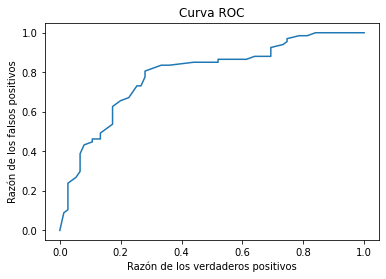

Área ROC con los datos de entrenamiento: 0.7903482587064676


In [85]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('Razón de los falsos positivos')
plt.xlabel('Razón de los verdaderos positivos')
plt.title('Curva ROC')
plt.show()
print('Área ROC con los datos de entrenamiento: ' + str(trainingSummary.areaUnderROC))

**3. Evaluar**

In [86]:
predict_test=lr_model.transform(testData)
predict_test.select('AproboInt','prediction','probability').show(10)

+---------+----------+--------------------+
|AproboInt|prediction|         probability|
+---------+----------+--------------------+
|        0|       0.0|[0.93147644818368...|
|        0|       0.0|[0.90810574583581...|
|        0|       0.0|[0.90810574583581...|
|        0|       0.0|[0.84180731202122...|
|        0|       0.0|[0.74130306394334...|
|        0|       0.0|[0.67565640084780...|
|        1|       0.0|[0.67565640084780...|
|        1|       1.0|[0.37218699872475...|
|        1|       1.0|[0.30513571901391...|
|        1|       1.0|[0.24198435321273...|
+---------+----------+--------------------+
only showing top 10 rows



In [87]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='AproboInt')
print('Área ROC con los datos de evaluación', evaluator.evaluate(predict_test))

Área ROC con los datos de evaluación 0.664079822616408


####**Árboles de decisión para clasificación**

El funcionamiento es similar a los árboles de regresión, solo que en este caso la variable a predecir es categórica.

A partir del conjunto histórico de datos se construye en árbol que tiene en sus nodos una pregunta sobre alguno de los atributos y en las hojas alguna de las categorías de la variable objetivo

**Modelar**

In [88]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="AproboInt", featuresCol="features")
dt_model=dt.fit(trainingData)

In [89]:
predict_train = dt_model.transform(trainingData)
predict_train.select('AproboInt','prediction').show(5)

+---------+----------+
|AproboInt|prediction|
+---------+----------+
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
+---------+----------+
only showing top 5 rows



**Evaluar**

In [90]:
predict_test = dt_model.transform(testData)

Veamos la precisión del clasificador

In [91]:
from sklearn.metrics import classification_report, confusion_matrix

clase_real = predict_test.select(['AproboInt']).collect()
clase_prediccion = predict_test.select(['prediction']).collect()

print("Medidas de error")
print(classification_report(clase_real, clase_prediccion))
print("Matriz de confusión")
print(confusion_matrix(clase_real, clase_prediccion))
evaluator = BinaryClassificationEvaluator(labelCol='AproboInt')
print('Área ROC con los datos de evaluación', evaluator.evaluate(predict_test))

Medidas de error
              precision    recall  f1-score   support

           0       0.50      0.52      0.51        33
           1       0.60      0.59      0.59        41

    accuracy                           0.55        74
   macro avg       0.55      0.55      0.55        74
weighted avg       0.56      0.55      0.55        74

Matriz de confusión
[[17 16]
 [17 24]]
Área ROC con los datos de evaluación 0.5606060606060607


####**Redes neuronales**

Las redes neuronales son modelos computacionales inspirados en sistemas biológicos, adaptados y simulados en computadoras convencionales. Buscan simular en un algoritmo la forma como se comportan las neuronas del cerebro humano.

Cada neurona tiene variables de entrada (atributos) que son multiplicados por un vector de pesos y el resultado es llevado a un mezclador lineal. A la salida del mezclador lineal se aplica una función de activación que puede ser tan sencilla o compleja como se quiera, el resultado es la salida de la neurona.

Las neuronas no trabajan solas, los resultados de cada neurona pueden ser llevados a varias neuronas que los utilizan como entradas. En este caso diremos que la red neuronal puede tener varias capas y dentro de cada capa se puede tener varias neuronas 

**Multilayer Perceptron**

Es una red neuronal con alimentación hacia adelante, compuesta de varias capas de neuronas entre la entrada y la salida de la misma, esta red permite establecer regiones de decisión mucho más complejas que las de dos semiplanos.

Como **función de activación** puede utilizar:
* Hardlim: Función escalón entre 0 y 1
* Hardlims: Función escalón simétrica entre -1 y 1

Multilayer perceptron utiliza la siguiente **regla de aprendizaje**:
* Pesos: $$w_{i+1} = w_i + (y_i - y_i')x_i $$
* Variable independiente: $$b_{i+1} = b_i + (y_i - y_i')$$

Donde,

* $w_{i+1}$: Peso de la neurona en la siguiente iteración
* $w_i$: Peso de la neurona en la iteración actual
* $y_i$: Salida real
* $y_i'$: Predicción
* $x_i$: Entrada actual de la neurona
* $b_{i+1}$: Entrada independiente en la siguiente iteración
* $b_i$: Entrada independiente en la iteración actual



**Modelar**

In [92]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
nn= MultilayerPerceptronClassifier(labelCol='AproboInt', featuresCol='features', maxIter=100, layers=[9, 5, 2])
nn_model = nn.fit(trainingData)

In [93]:
predict_train = nn_model.transform(trainingData)

**Evaluar**

In [94]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#Predicción
predict_test = nn_model.transform(testData)
predict_test.select('prediction', 'AproboInt').show(5)

#Exactitud
evaluator = MulticlassClassificationEvaluator(metricName="accuracy", labelCol='AproboInt')
print("Exactitud con los datos de evaluación = " + str(evaluator.evaluate(predict_test)))

#Matriz de confusión
clase_real = predict_test.select(['AproboInt']).collect()
clase_prediccion = predict_test.select(['prediction']).collect()
print("Matriz de confusión")
print(confusion_matrix(clase_real, clase_prediccion))

+----------+---------+
|prediction|AproboInt|
+----------+---------+
|       0.0|        0|
|       0.0|        0|
|       0.0|        0|
|       0.0|        0|
|       0.0|        0|
+----------+---------+
only showing top 5 rows

Exactitud con los datos de evaluación = 0.6621621621621622
Matriz de confusión
[[27  6]
 [19 22]]


####**Máquinas de Soporte Vectorial**

Las máquinas de soporte vectorial plantean la solución de un problema complejo (no separable linealmente) en un espacio de dimensión superior mediante la construcción de un hiperplano de separación óptima de clases.

El hiper plano construido permite separar a cada lado del mismo los registros de cada categoría de la variable objetivo.

Para representar los datos en una dimensión superior se utiliza la matriz de Kernel

**Modelar**

In [95]:
from pyspark.ml.classification import LinearSVC
svc= LinearSVC(labelCol='AproboInt', featuresCol='features', maxIter=10, regParam=0.1)
svc_model = svc.fit(trainingData)

In [96]:
predict_train = svc_model.transform(trainingData)
predict_train.select('AproboInt', 'prediction').show(5)

+---------+----------+
|AproboInt|prediction|
+---------+----------+
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
+---------+----------+
only showing top 5 rows



**Evaluar**

In [97]:
predict_test = svc_model.transform(testData)
predict_test.select('prediction', 'AproboInt').show(5)
evaluator = BinaryClassificationEvaluator(labelCol='AproboInt')
print('Área ROC con los datos de evaluación', evaluator.evaluate(predict_test))

+----------+---------+
|prediction|AproboInt|
+----------+---------+
|       0.0|        0|
|       0.0|        0|
|       0.0|        0|
|       0.0|        0|
|       0.0|        0|
+----------+---------+
only showing top 5 rows

Área ROC con los datos de evaluación 0.5480413895048042


####**Método Bayesiano**

Los métodos bayesianos utilizan el teorema de la probabilidad condicional de bayes: La probabilidad de que algo ocurra dado que ya han ocurrido ciertos sucesos.

La probabilidad de que un registro $reg$ pertenezca a la clase $C_j$ se calcula como:
$$P(C_j/reg) = \frac{P(C_j)P(reg/C_j)}{P(reg)}$$

Donde,

* $P(C_j)$: Probabilidad de la clase $C_j$
* $P(reg/C_j)$: Probabilidad de que la clase $C_j$ sea la clase del registro $reg$
* $P(reg)$: Probabilidad de seleccionar un registro

Naive Bayes implementa un método bayesiano asumiendo que los registros son independientes, con esto la probabilidad de que un registro $reg$ pertenezca a la clase $C_j$ se resume como:

$$P(C_j/reg) = P(C_j)P(reg/C_j)$$


Con los datos históricos se construye una tabla de probabilidades, que indica la probabilidad de que un registro pertenezca a cada una de las categorías de la variable objetivo

Dado un registro nuevo, la predicción consistirá en evaluar la probabilidad de pertenencia de dicho registro a cada una de las clases escogiendo aquella que cuente con la mayor probabilidad.

**Modelar**

In [98]:
from pyspark.ml.classification import NaiveBayes
nb= NaiveBayes(labelCol='AproboInt', featuresCol='features')
nb_model = svc.fit(trainingData)

In [99]:
predict_train = nb_model.transform(trainingData)

**Evaluar**

In [100]:
predict_test = nb_model.transform(testData)
predict_test.select('prediction', 'AproboInt').show(5)
evaluator = BinaryClassificationEvaluator(labelCol='AproboInt')
print('Área ROC con los datos de evaluación', evaluator.evaluate(predict_test))

+----------+---------+
|prediction|AproboInt|
+----------+---------+
|       0.0|        0|
|       0.0|        0|
|       0.0|        0|
|       0.0|        0|
|       0.0|        0|
+----------+---------+
only showing top 5 rows

Área ROC con los datos de evaluación 0.5480413895048042


##**Aprendizaje NO Supervisado**

En el aprendizaje No Supervisado, NO se cuenta con datos históricos previamente etiquetados para la etapa de entrenamiento, en su lugar se dispone de datos actuales y lo que se haces es describir la estructura de esos datos actuales mediante un análisis exploratorio con el fin de facilitar el entendimiento de los datos.

###**Clustering**

Su objetivo es agrupar un conjunto de datos heterogéneo en grupos de datos homogéneos. En principio cada registro (fila) del conjunto de datos es diferente de los demás, por eso decimos que es heterogéneo, pero puede tener cierta similitud a un subconjunto de registros y es ahi donde se genera la agrupación, siendo cada subconjunto de datos (clúster) diferente a los demás subconjuntos.

La similaridad de los registros se expresa como una medida de distancia, de modo que un par de registros que se encuentre distante implicará que son diferentes, mientras que registros cercanos diremos que son similares

Dentro del **ciclo de vida** del Clustering se encuentran las siguientes etapas:
* Aprendizaje: Crear el modelo
* Evaluación: Evaluar el modelo
* Perfilamiento: Entender las características que definen a cada clúster (describir el centroide)


**Evaluación**

La evaluación del Clustering se basa en la comparación de dos medidas, estas medidas son:
* Cohesión o compacticidad: promedio de distancia de cada elemento a su centroide (distancia dentro del clúster)
* Separabilidad: promedio de distancias entre los centroides de los clústers (distancia entre clústers)

La comparación de estas dos medidas se expresa mediante índices, los mas conocidos son:

* Dunn
* Davies-Bouldin
* Silueta


####**K-means**

Divide el conjunto de datos en un número predefinido de grupos k. Es el método más comúnmente utilizado, la idea del método es definir k centroides, uno por clúster, y los datos son asociados al centroide más cercano.


**Ejemplo: Titanic**

**Preparar**

In [101]:
data = sqlCtx.read.option("header",True) \
      .option("delimiter",";") \
     .csv("local/data/titanic.csv")
data.show(5)

+-------+------+------+----------+
|  Clase|  Edad|  Sexo|Sobrevivio|
+-------+------+------+----------+
|Primera|Adulto|Hombre|        Si|
|Primera|Adulto|Hombre|        Si|
|Primera|Adulto|Hombre|        Si|
|Primera|Adulto|Hombre|        Si|
|Primera|Adulto|Hombre|        Si|
+-------+------+------+----------+
only showing top 5 rows



In [102]:
def func_Clase(value):
  if value=="Tripulacion":
    return 0
  if value=="Primera":
    return 1
  if value=="Segunda":
    return 2
  if value=="Tercera":
    return 3

In [103]:
def func_Edad(value):
  if value=="Adulto":
    return 1
  else:
    return 0

In [104]:
def func_Sexo(value):
  if value=="Hombre":
    return 1
  else:
    return 0

In [105]:
def func_Sobrevivio(value):
  if value=="Si":
    return 1
  else:
    return 0

In [106]:
data.registerTempTable("Titanic")
sqlCtx.registerFunction("func_clase",func_Clase)
sqlCtx.registerFunction("func_edad",func_Edad)
sqlCtx.registerFunction("func_sexo",func_Sexo)
sqlCtx.registerFunction("func_sobrevivio",func_Sobrevivio)

<function __main__.func_Sobrevivio>

In [107]:
titanic = sqlCtx.sql("""
		SELECT func_clase(Clase) AS ClaseInt, func_edad(Edad) AS EdadInt, 
      func_sexo(Sexo) AS SexoInt, func_sobrevivio(Sobrevivio) AS SobrevivioInt
		FROM Titanic
		""")
titanic.distinct().show()

+--------+-------+-------+-------------+
|ClaseInt|EdadInt|SexoInt|SobrevivioInt|
+--------+-------+-------+-------------+
|       0|      1|      1|            1|
|       3|      1|      0|            1|
|       3|      0|      0|            1|
|       0|      1|      1|            0|
|       1|      0|      0|            1|
|       1|      1|      1|            0|
|       3|      0|      1|            1|
|       2|      1|      0|            1|
|       3|      1|      1|            1|
|       2|      1|      1|            1|
|       0|      1|      0|            1|
|       1|      1|      0|            1|
|       1|      1|      0|            0|
|       2|      0|      0|            1|
|       2|      1|      1|            0|
|       1|      0|      1|            1|
|       2|      0|      1|            1|
|       3|      1|      0|            0|
|       2|      1|      0|            0|
|       3|      0|      0|            0|
+--------+-------+-------+-------------+
only showing top

In [108]:
titanic.printSchema()

root
 |-- ClaseInt: string (nullable = true)
 |-- EdadInt: string (nullable = true)
 |-- SexoInt: string (nullable = true)
 |-- SobrevivioInt: string (nullable = true)



In [109]:
titanic = titanic.withColumn("ClaseInt", titanic["ClaseInt"].cast(IntegerType()))
titanic = titanic.withColumn("EdadInt", titanic["EdadInt"].cast(IntegerType()))
titanic = titanic.withColumn("SexoInt", titanic["SexoInt"].cast(IntegerType()))
titanic = titanic.withColumn("SobrevivioInt", titanic["SobrevivioInt"].cast(IntegerType()))
data=titanic
data.printSchema()

root
 |-- ClaseInt: integer (nullable = true)
 |-- EdadInt: integer (nullable = true)
 |-- SexoInt: integer (nullable = true)
 |-- SobrevivioInt: integer (nullable = true)



In [110]:
vectorAssembler = VectorAssembler(inputCols = data.columns, outputCol = 'features', handleInvalid="skip")
vdata = vectorAssembler.transform(data)
vdata.cache()
vdata.show(5)

+--------+-------+-------+-------------+-----------------+
|ClaseInt|EdadInt|SexoInt|SobrevivioInt|         features|
+--------+-------+-------+-------------+-----------------+
|       1|      1|      1|            1|[1.0,1.0,1.0,1.0]|
|       1|      1|      1|            1|[1.0,1.0,1.0,1.0]|
|       1|      1|      1|            1|[1.0,1.0,1.0,1.0]|
|       1|      1|      1|            1|[1.0,1.0,1.0,1.0]|
|       1|      1|      1|            1|[1.0,1.0,1.0,1.0]|
+--------+-------+-------+-------------+-----------------+
only showing top 5 rows



**Modelar**

In [111]:
from pyspark.ml.clustering import KMeans
km = KMeans( featuresCol='features', k=3, predictionCol='cluster', distanceMeasure='euclidean')
km_model = km.fit(vdata)

Veamos en cuál cluster quedó cada registro

In [112]:
predictions = km_model.transform(vdata)
predictions.distinct().show()

+--------+-------+-------+-------------+-----------------+-------+
|ClaseInt|EdadInt|SexoInt|SobrevivioInt|         features|cluster|
+--------+-------+-------+-------------+-----------------+-------+
|       2|      1|      1|            0|[2.0,1.0,1.0,0.0]|      1|
|       3|      0|      1|            1|[3.0,0.0,1.0,1.0]|      1|
|       2|      1|      1|            1|[2.0,1.0,1.0,1.0]|      2|
|       1|      1|      0|            0|[1.0,1.0,0.0,0.0]|      2|
|       1|      0|      1|            1|[1.0,0.0,1.0,1.0]|      2|
|       0|      1|      0|            1|[0.0,1.0,0.0,1.0]|      0|
|       3|      0|      0|            1|[3.0,0.0,0.0,1.0]|      1|
|       1|      1|      1|            1|[1.0,1.0,1.0,1.0]|      2|
|       3|      1|      0|            1|[3.0,1.0,0.0,1.0]|      1|
|       3|      1|      0|            0|[3.0,1.0,0.0,0.0]|      1|
|       3|      0|      0|            0|    (4,[0],[3.0])|      1|
|       1|      1|      0|            1|[1.0,1.0,0.0,1.0]|    

Veamos los centroides de cada cluster

In [113]:
centers = km_model.clusterCenters()
print("Centroides: ")
for center in centers:
  centerR=[round(num, 0) for num in center]
  print(centerR)
print("Variables")
data.columns

Centroides: 
[0.0, 1.0, 1.0, 0.0]
[3.0, 1.0, 1.0, 0.0]
[1.0, 1.0, 0.0, 1.0]
Variables


['ClaseInt', 'EdadInt', 'SexoInt', 'SobrevivioInt']

**Evaluar**

In [114]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator(predictionCol='cluster')
silhouette = evaluator.evaluate(predictions)
print("Índice de la silueta = " + str(silhouette))

Índice de la silueta = 0.662889511796819


Aumentemos el número de clústers

In [115]:
#modelar
km = KMeans( featuresCol='features', k=18, predictionCol='cluster', distanceMeasure='euclidean')
km_model = km.fit(vdata)

#Asignación de clusters
predictions = km_model.transform(vdata)

#Evaluar
evaluator = ClusteringEvaluator(predictionCol='cluster')
silhouette = evaluator.evaluate(predictions)
print("Índice de la silueta = " + str(silhouette))

#Centroides
centers = km_model.clusterCenters()
print("Centroides: ")
for center in centers:
  centerR=[round(num, 0) for num in center]
  print(centerR)
print("Variables")
data.columns

Índice de la silueta = 0.9534583627227384
Centroides: 
[1.0, 1.0, 0.0, 1.0]
[1.0, 1.0, 1.0, 0.0]
[3.0, 1.0, 1.0, 1.0]
[3.0, 1.0, 1.0, 0.0]
[3.0, 1.0, 0.0, 1.0]
[3.0, 1.0, 0.0, 0.0]
[3.0, 0.0, 1.0, 1.0]
[0.0, 1.0, 1.0, 1.0]
[0.0, 1.0, 1.0, 0.0]
[1.0, 1.0, 1.0, 1.0]
[1.0, 0.0, 1.0, 1.0]
[2.0, 1.0, 1.0, 0.0]
[2.0, 1.0, 0.0, 1.0]
[2.0, 1.0, 0.0, 0.0]
[2.0, 0.0, 1.0, 1.0]
[2.0, 0.0, 0.0, 1.0]
[3.0, 0.0, 1.0, 0.0]
[3.0, 0.0, 0.0, 1.0]
Variables


['ClaseInt', 'EdadInt', 'SexoInt', 'SobrevivioInt']

Cómo podemos saber cuántos clúter deberíamos crear?

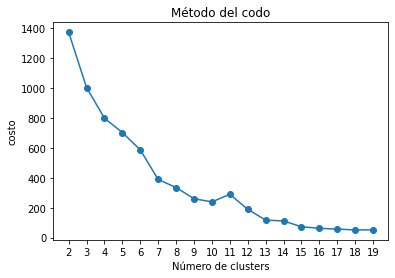

In [116]:
from pyspark.ml.clustering import KMeans
kini=2; kfin=20
ks = range(kini, kfin)
costo=[]
for k in range(kini, kfin):
    kmeans= KMeans( featuresCol='features', k=k, predictionCol='cluster', distanceMeasure='euclidean')
    model = kmeans.fit(vdata)
    costo.append(model.summary.trainingCost)
plt.plot(ks, costo, '-o')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('costo')
plt.xticks(ks)
plt.show()

#**Ejemplos**

##**Filtrado Colaborativo**

Recomendación de películas a partir de la calificación ingresada por los usuarios

**Preparar**

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
lines = sc.textFile("local/data/movielens.txt")
parts = lines.map(lambda row: row.split("::"))
ratingsRDD = parts.map(lambda p: (int (p[0]), int (p[1]), float (p[2])))
ratingsRDD.take(10)

In [ ]:
ratings = sqlCtx.createDataFrame(ratingsRDD, ["usuario","pelicula","calificacion"])
(training, test) = ratings.randomSplit([0.7, 0.3])
training.show(10)

**Modelar**

In [ ]:
als = ALS(maxIter=5, regParam=0.01, userCol="usuario", itemCol="pelicula", ratingCol="calificacion",
          coldStartStrategy="drop")
model = als.fit(training)

**Evaluar**

In [ ]:
predictions = model.transform(test)
predictions.show(5)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="calificacion",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Raiz del error cuadrático medio = " + str(rmse))

**Películas recomendadas para cada usuario**

In [ ]:
userRecs = model.recommendForAllUsers(2)
userRecs.take(5)

**Usuarios recomendados para cada película**

In [ ]:
movieRecs = model.recommendForAllItems(2)
movieRecs.take(5)

**Películas recomendadas para una lista de usuarios específica**

In [ ]:
users = ratings.select(als.getUserCol()).distinct().limit(3)
userSubsetRecs = model.recommendForUserSubset(users, 5)
userSubsetRecs.collect()

**Usuarios recomendados para una lista de películas específica**

In [ ]:
movies = ratings.select(als.getItemCol()).distinct().limit(3)
movieSubSetRecs = model.recommendForItemSubset(movies, 5)
movieSubSetRecs.collect()

#**Ejercicios**

**Población atendida en hospital de Envigado**

El archivo poblacion_atendida.csv contiene información sobre los pacientes atendidos en un Hospital en Envigado. Para cada paciente se tiene la siguiente información:

* SEXO	
* ESTADO_CIVIL	
* ZONA_RES	
* MUN_RES	
* PAIS_NCTO	
* EDAD	
* ESCOLARIDAD_PACIENTE

Fuente de los datos:
https://www.datos.gov.co/Salud-y-Protecci-n-Social/Poblaci-n-Atendida-a-o-2020/4ike-xz34

A) Aplique Kmeans para crear clústers que permitan describir  los tipos de pacientes 

B) Usando el clúster asignado a cada paciente como variable objetivo, cree un modelo predictivo que permita predecir el grupo al que pertenece cada paciente

C) Cree un archivo con la información de tres nuevos pacientes y utilice el modelo de predicción creado anteriormente para predecir el clúster al que pertenecerían los nuevos pacientes